# Compas Analysis


## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import keras 
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Concatenate

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = 100

In [5]:
raw_data = pd.read_csv('./compas-scores-two-years.csv',delimiter=',')

In [6]:
raw_data.columns

Index([u'id', u'name', u'first', u'last', u'compas_screening_date', u'sex',
       u'dob', u'age', u'age_cat', u'race', u'juv_fel_count', u'decile_score',
       u'juv_misd_count', u'juv_other_count', u'priors_count',
       u'days_b_screening_arrest', u'c_jail_in', u'c_jail_out',
       u'c_case_number', u'c_offense_date', u'c_arrest_date',
       u'c_days_from_compas', u'c_charge_degree', u'c_charge_desc',
       u'is_recid', u'r_case_number', u'r_charge_degree',
       u'r_days_from_arrest', u'r_offense_date', u'r_charge_desc',
       u'r_jail_in', u'r_jail_out', u'violent_recid', u'is_violent_recid',
       u'vr_case_number', u'vr_charge_degree', u'vr_offense_date',
       u'vr_charge_desc', u'type_of_assessment', u'decile_score.1',
       u'score_text', u'screening_date', u'v_type_of_assessment',
       u'v_decile_score', u'v_score_text', u'v_screening_date', u'in_custody',
       u'out_custody', u'priors_count.1', u'start', u'end', u'event',
       u'two_year_recid'],
      dtype

## Notes from COMPAS analysis:
However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [7]:
data_df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
data_df = data_df[data_df.days_b_screening_arrest <= 30]
data_df = data_df[data_df.days_b_screening_arrest >= -30]
data_df = data_df[data_df.is_recid != -1]
data_df = data_df[data_df.c_charge_degree != "O"]
data_df = data_df[data_df.score_text != 'N/A']

In [8]:
data_df.shape

(6172, 13)

## Define Metrics

In [9]:
# helper score to decision functions
def threshold_round(scores, threshold=0.5, noise=False, mean=0, std=0.1):
    if noise: scores = add_noise(scores, mean, std)
    rounded_preds = np.array(scores >= threshold, dtype=float)
    return rounded_preds

def add_noise(scores, mean=0, std=.1):
    noise = np.random.normal(mean,std,scores.shape)
    return scores + noise

def noisy_window(scores, lower_limit, upper_limit, mean=0, std=0.1):
    scores_copy = np.copy(scores)
    noisy_scores = add_noise(scores, mean, std)
    scores_copy[(scores_copy >= lower_limit) & (scores_copy <= upper_limit)] = noisy_scores[(scores_copy >= lower_limit) & (scores_copy <= upper_limit)]
    return scores_copy

In [96]:
# Calibration
def get_calibration_curve(preds, true):
    pred_calibration_arr = []
    scores = []
    for score in sorted(np.unique(preds)): 
        scores.append(score)
        actual_recid_for_score = true[preds == score]
        actual_prob = sum(actual_recid_for_score)*1.0/len(actual_recid_for_score)
        pred_calibration_arr.append(actual_prob)
    return pred_calibration_arr, scores

# fpr
def fpr(true, decisions):
    tn, fp, fn, tp = confusion_matrix(true, decisions).ravel()
    fpr = float(fp) / (fp + tn)
    return fpr

# fnr
def fnr(true, decisions):
    tn, fp, fn, tp = confusion_matrix(true, decisions).ravel()
    fnr = float(fn) / (fn + tp)
    return fnr

# Disparate Impact
def disparate_impact(group_a_decs, group_b_decs, group_a_true, group_b_true):
    fpr_diff = fpr(group_a_true, group_a_decs) - fpr(group_b_true, group_b_decs)
    return fpr_diff

## Build a Model

Building a model to predict recidivism (using age, charge type, # of prior convictions) in case at some point we want to add constraints + modify it instead of just using the existing COMPAS scores.

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [109]:
data_train, data_test = train_test_split(data_df, test_size = 0.25, random_state = 0, stratify = data_df.two_year_recid)

In [110]:
X_train = pd.get_dummies(data_train[['age_cat', 'c_charge_degree', 'priors_count']])
X_test = pd.get_dummies(data_test[['age_cat', 'c_charge_degree', 'priors_count']])
Y_train = data_train['two_year_recid']
Y_test = data_test['two_year_recid']

In [111]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
preds = lr.predict_proba(X_test)[:,1]

In [112]:
accuracy = lr.score(X_test, Y_test)
auc = roc_auc_score(Y_test, preds)

In [16]:
accuracy, auc

(0.6740116655865198, 0.7343381065140875)

In [84]:
preds = np.array([round(p, 1) for p in preds])

In [18]:
true_recid_white = Y_test[data_test.race == 'Caucasian']
true_recid_aa = Y_test[data_test.race == 'African-American']

In [19]:
idx_white = data_train.race == 'Caucasian'
idx_aa = data_train.race == 'African-American'

### Model Calibration + FPR + DI

In [20]:
all_calibration = get_calibration_curve(preds, Y_test)
white_calibration = get_calibration_curve(preds[data_test.race == 'Caucasian'], true_recid_white)
aa_calibration = get_calibration_curve(preds[data_test.race == 'African-American'], true_recid_aa)

(0, 1)

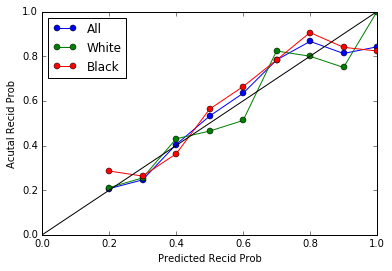

In [21]:
plt.plot(np.unique(preds), all_calibration, label = 'All', marker = 'o')
plt.plot(np.unique(preds), white_calibration, label = 'White', marker = 'o')
plt.plot(np.unique(preds), aa_calibration, label = 'Black', marker = 'o')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.xlabel('Predicted Recid Prob')
plt.ylabel('Acutal Recid Prob')
plt.legend(loc=2)
plt.xlim(0, 1)
plt.ylim(0, 1)

Assuming DM that rounds up or down based on 0.5 threshold and follows exactly:

In [22]:
decisions_white = threshold_round(preds[data_test.race == 'Caucasian']) 
decisions_aa = threshold_round(preds[data_test.race == 'African-American'])

In [23]:
print "fpr (white): " + str(fpr(true_recid_white, decisions_white))
print "fpr (black): " + str(fpr(true_recid_aa, decisions_aa))

fpr (white): 0.248447204969
fpr (black): 0.427055702918


In [24]:
print "disparate impact (for fpr): {}".format(disparate_impact(decisions_white,
                                                               decisions_aa,
                                                               true_recid_white,
                                                               true_recid_aa))

disparate impact (for fpr): -0.178608497949


## Actual COMPAS score calibration + FPR + DI

In [25]:
scores = data_test.decile_score / 10.
scores_white = scores[data_test.race == 'Caucasian']
scores_aa = scores[data_test.race == 'African-American']

scores = np.array([round(s, 1) for s in scores])
scores_white = np.array([round(s, 1) for s in scores_white])
scores_aa = np.array([round(s, 1) for s in scores_aa])

# Decisions are just rounded scores.
decisions = threshold_round(scores)
decisions_white = decisions[data_test.race == 'Caucasian']
decisions_aa = decisions[data_test.race == 'African-American']

In [26]:
accuracy = sum(decisions == np.array(Y_test)) / float(len(Y_test))
auc = roc_auc_score(Y_test, scores)

In [27]:
accuracy, auc

(0.6668826960466624, 0.7204818236328343)

In [28]:
all_calibration = get_calibration_curve(scores, Y_test)
white_calibration = get_calibration_curve(scores_white, true_recid_white)
aa_calibration = get_calibration_curve(scores_aa, true_recid_aa)

(0, 1)

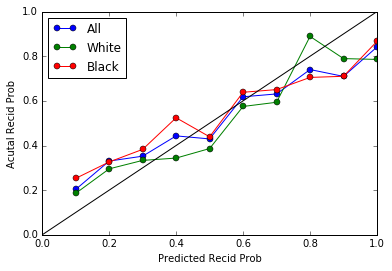

In [29]:
x_axis = np.unique(data_test.decile_score / 10.)
plt.plot(x_axis, all_calibration, label = 'All', marker = 'o')
plt.plot(x_axis, white_calibration, label = 'White', marker = 'o')
plt.plot(x_axis, aa_calibration, label = 'Black', marker = 'o')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.xlabel('Predicted Recid Prob')
plt.ylabel('Acutal Recid Prob')
plt.legend(loc=2)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [30]:
print "fpr (white): " + str(fpr(true_recid_white, decisions_white))
print "fpr (black): " + str(fpr(true_recid_aa, decisions_aa))

fpr (white): 0.204968944099
fpr (black): 0.413793103448


In [31]:
print "disparate impact (for fpr): {}".format(disparate_impact(decisions_white,
                                                               decisions_aa,
                                                               true_recid_white,
                                                               true_recid_aa))

disparate impact (for fpr): -0.208824159349


In [32]:
# what is the decision?  release or detain
# what is the outcome? recidivate in 2 yrs or not - sort of weird and indirect

Note: this is a bit complicated because deviation from the score is not necessarily *bad* because the score itself isn't that great. 

## g(x) #1: different thresholds for decision-making
If prior belief is "African American defendants are riskier", change threshold for predicting recid or not to be lower for those defendants (instead of simply rounding at 0.5).

For example, using a threshold of 0.4 for African American defendants:

In [33]:
decisions_white = threshold_round(scores_white)
decisions_aa = threshold_round(scores_aa, threshold=0.4)

In [34]:
print "fpr (white): {}".format(fpr(true_recid_white, decisions_white))
print "fpr (black): {}".format(fpr(true_recid_aa, decisions_aa))

fpr (white): 0.204968944099
fpr (black): 0.51724137931


In [35]:
fprs = []
dis = []
for th in np.arange(0.1, 0.6, 0.1):
    decisions_aa = threshold_round(scores_aa, threshold=th)
    fprs.append(fpr(true_recid_aa, decisions_aa))
    dis.append(disparate_impact(decisions_white, 
                                decisions_aa, 
                                true_recid_white,
                                true_recid_aa))

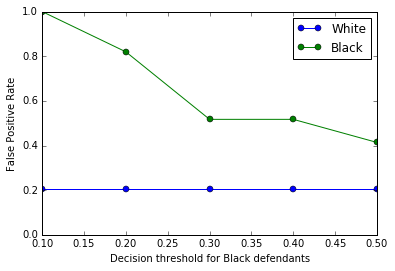

In [36]:
xaxis = np.arange(0.1, 0.6, 0.1)
plt.plot(xaxis, 
         np.full(len(xaxis), fpr(true_recid_white, decisions_white)),
         label = 'White', marker='o')
plt.plot(xaxis, fprs, label= 'Black', marker='o')
plt.xlabel('Decision threshold for Black defendants')
plt.ylabel('False Positive Rate')
plt.ylim(0,1)
plt.legend()

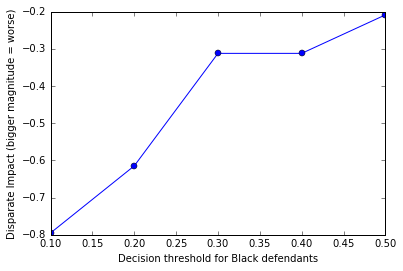

In [37]:
xaxis = np.arange(0.1, 0.6, 0.1)
plt.plot(xaxis, dis, marker='o')
plt.xlabel('Decision threshold for Black defendants')
plt.ylabel('Disparate Impact (bigger magnitude = worse)')

Let's try with the predicted scores, so we can modify the alg: 

A Logistic Regression predicts f(x) = s from x.  A thresholding function g(s) = y predicts the outcome.  If we didn't know that g was a thresholding function, how would we parameterize it? 

In [38]:
x = Input(shape=(6,))
y = Dense(1, activation='sigmoid')(x)
model = Model(inputs=x, outputs=y)

In [39]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
4629/4629 [==============================] - 0s 65us/step - loss: 1.3875 - acc: 0.4081
Epoch 2/10
4629/4629 [==============================] - 0s 26us/step - loss: 1.1342 - acc: 0.3647
Epoch 3/10
4629/4629 [==============================] - 0s 27us/step - loss: 0.9277 - acc: 0.3545
Epoch 4/10
4629/4629 [==============================] - 0s 27us/step - loss: 0.7783 - acc: 0.3677
Epoch 5/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6953 - acc: 0.4681
Epoch 6/10
4629/4629 [==============================] - 0s 27us/step - loss: 0.6613 - acc: 0.6317
Epoch 7/10
4629/4629 [==============================] - 0s 28us/step - loss: 0.6437 - acc: 0.6747
Epoch 8/10
4629/4629 [==============================] - 0s 29us/step - loss: 0.6345 - acc: 0.6716
Epoch 9/10
4629/4629 [==============================] - 0s 27us/step - loss: 0.6297 - acc: 0.6719
Epoch 10/10
4629/4629 [==============================] - 0s 28us/step - loss: 0.6268 - acc: 0.6744


In [40]:
acc = model.evaluate(X_test, Y_test)[1]
preds = model.predict(X_test).flatten()
auc = roc_auc_score(Y_test, preds)
acc, auc

1543/1543 [==============================] - 0s 26us/step


In [198]:
keras.backend.clear_session()

In [199]:
x = Input(shape=(6,))
s = Dense(1, activation='sigmoid')(x)
score_model = Model(inputs=x, outputs=s)

xs = Concatenate(axis=1)([x,s])
d1 = Dense(8, activation='relu')(xs)
y = Dense(1, activation='sigmoid')(d1)
#human_model = Model(inputs=xs, outputs=y)

overall_model = Model(inputs=x, outputs=y)

In [200]:
# Step 1: Train a starting model with X and Y = recidivism (normal labels)

In [201]:
score_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
score_model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
4629/4629 [==============================] - 0s 55us/step - loss: 0.6943 - acc: 0.5993
Epoch 2/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6426 - acc: 0.6407
Epoch 3/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6323 - acc: 0.6537
Epoch 4/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6286 - acc: 0.6561
Epoch 5/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6265 - acc: 0.6667
Epoch 6/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6248 - acc: 0.6669
Epoch 7/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6236 - acc: 0.6647
Epoch 8/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6228 - acc: 0.6684
Epoch 9/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6222 - acc: 0.6682
Epoch 10/10
4629/4629 [==============================] - 0s 26us/step - loss: 0.6217 - acc: 0.6690


In [202]:
for i in range(5):
    # Step 2: Get human decisions for these scores to start training human model
    # This is training the second half of the network to mimic human decisions
    scores = score_model.predict(X_train)
    scores_with_race = pd.DataFrame({'score': scores.flatten()})
    scores_with_race['race'] = data_train.race.reset_index(drop=True)

    decision_train = scores_with_race.apply(lambda row: threshold_round(row.score, threshold=0.3) 
                           if row['race'] == "African-American" 
                           else threshold_round(row.score), axis=1)
    
    # Freeze weights for score model
    s.trainable = False
    d1.trainable = True
    y.trainable = True
    overall_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    overall_model.fit(X_train, decision_train, epochs=10, batch_size=32)
    
    # Step 3: Freeze human part and retrain scores to get scores that will lead to the right decision
    
    s.trainable = True
    d1.trainable = False
    y.trainable = False
    overall_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    overall_model.fit(X_train, Y_train, epochs=10, batch_size=32)
    

Epoch 1/10
4629/4629 [==============================] - 0s 73us/step - loss: 0.7521 - acc: 0.6051
Epoch 2/10
4629/4629 [==============================] - 0s 33us/step - loss: 0.4719 - acc: 0.7835
Epoch 3/10
4629/4629 [==============================] - 0s 33us/step - loss: 0.4170 - acc: 0.7911
Epoch 4/10
4629/4629 [==============================] - 0s 34us/step - loss: 0.3934 - acc: 0.7933
Epoch 5/10
4629/4629 [==============================] - 0s 33us/step - loss: 0.3826 - acc: 0.7909
Epoch 6/10
4629/4629 [==============================] - 0s 40us/step - loss: 0.3781 - acc: 0.7924
Epoch 7/10
4629/4629 [==============================] - 0s 32us/step - loss: 0.3756 - acc: 0.7939
Epoch 8/10
4629/4629 [==============================] - 0s 39us/step - loss: 0.3744 - acc: 0.7909
Epoch 9/10
4629/4629 [==============================] - 0s 35us/step - loss: 0.3735 - acc: 0.7905
Epoch 10/10
4629/4629 [==============================] - 0s 34us/step - loss: 0.3726 - acc: 0.7917
Epoch 1/10
4629/462

In [203]:
new_scores = score_model.predict(X_train).flatten()
new_scores = np.array([round(p, 1) for p in new_scores])
new_scores_with_race = pd.DataFrame({'score': new_scores})
new_scores_with_race['race'] = data_train.race.reset_index(drop=True)

In [204]:
Y_train_with_race = pd.DataFrame({'Y': Y_train.copy()})
Y_train_with_race['race'] = data_train.race

In [205]:
white_calibration, x_axis_1 = get_calibration_curve(new_scores_with_race[new_scores_with_race.race == 'Caucasian'].score.reset_index(drop=True), 
                                          Y_train_with_race[Y_train_with_race.race == 'Caucasian'].Y.reset_index(drop=True))

aa_calibration, x_axis_2 = get_calibration_curve(new_scores_with_race[new_scores_with_race.race == 'African-American'].score.reset_index(drop=True), 
                                          Y_train_with_race[Y_train_with_race.race == 'African-American'].Y.reset_index(drop=True))


In [206]:
white_calibration, x_axis_1

([0.13114754098360656,
  0.29411764705882354,
  0.12307692307692308,
  0.3902439024390244,
  0.3288590604026846,
  0.2958579881656805,
  0.5188442211055276],
 [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

(0, 1)

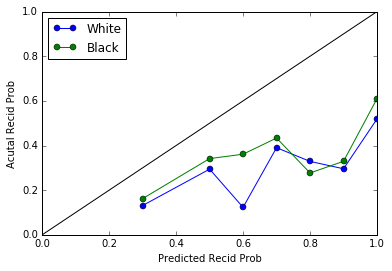

In [207]:
x_axis = np.unique(data_test.decile_score / 10.)
plt.plot(x_axis_1, white_calibration, label = 'White', marker = 'o')
plt.plot(x_axis_2, aa_calibration, label = 'Black', marker = 'o')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.xlabel('Predicted Recid Prob')
plt.ylabel('Acutal Recid Prob')
plt.legend(loc=2)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [208]:
decisions_white = threshold_round(new_scores_with_race[new_scores_with_race.race == 'Caucasian'].score.reset_index(drop=True))
decisions_aa = threshold_round(new_scores_with_race[new_scores_with_race.race == 'African-American'].score.reset_index(drop=True), threshold=0.4)

In [209]:
print "fpr (white): {}".format(fpr(Y_train_with_race[Y_train_with_race.race == 'Caucasian'].Y.reset_index(drop=True), decisions_white))
print "fpr (black): {}".format(fpr(Y_train_with_race[Y_train_with_race.race == 'African-American'].Y.reset_index(drop=True), decisions_aa))

fpr (white): 0.889468196038
fpr (black): 0.97273526825


In [210]:
preds = overall_model.predict(X_test)

In [211]:
overall_model.evaluate(X_test, Y_test)

1543/1543 [==============================] - 0s 84us/step


[0.6065147539971327, 0.6830848995656529]

In [212]:
auc = roc_auc_score(Y_test, preds)
auc

0.7251423654515212

In [213]:
original_preds = lr.predict_proba(X_train)[:,1]

In [214]:
new_preds = score_model.predict(X_train)

(array([2.35787419, 3.49429224, 1.87083788, 1.10549511, 1.87856862,
        0.78080424, 0.42519043, 0.18553764, 0.10823029, 0.06184588]),
 array([0.1774311 , 0.25893948, 0.34044787, 0.42195625, 0.50346463,
        0.58497302, 0.6664814 , 0.74798979, 0.82949817, 0.91100656,
        0.99251494]),
 <a list of 10 Patch objects>)

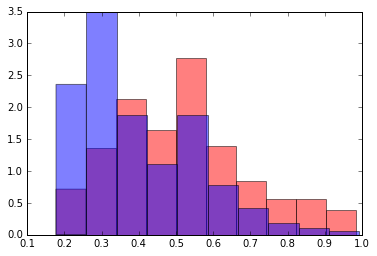

In [215]:
plt.hist(original_preds[idx_aa], color='red', alpha=0.5, normed=True)
plt.hist(original_preds[idx_white], color='blue', alpha=0.5, normed=True)

(array([5.98022526, 1.07798052, 0.09624827, 0.03208275, 0.0898317 ,
        0.        , 0.14116406, 0.21174622, 0.20532954, 2.34845809]),
 array([2.7755483e-13, 9.8202251e-02, 1.9640450e-01, 2.9460675e-01,
        3.9280900e-01, 4.9101126e-01, 5.8921349e-01, 6.8741578e-01,
        7.8561801e-01, 8.8382030e-01, 9.8202252e-01], dtype=float32),
 <a list of 10 Patch objects>)

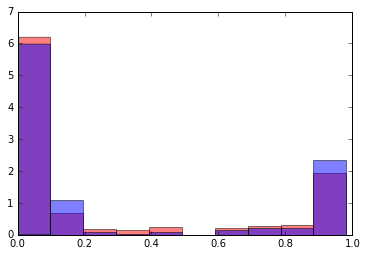

In [197]:
plt.hist(new_preds.flatten()[idx_aa], color='red', alpha=0.5, normed=True)
plt.hist(new_preds.flatten()[idx_white], color='blue', alpha=0.5, normed=True)

## g(x) #2: More likely to switch decision in high-risk preds for white defendants (e.g., imagine some factors that sway judge that are not in the data)

Implementation: scores between 0.7 and 1 have random *negative* noise added for white defendants 

In [36]:
decisions_white = threshold_round(noisy_window(scores_white, 0.7, 1.0, mean=-0.1, std=0.1))
decisions_aa = threshold_round(scores_aa)

In [37]:
print "fpr (white): {}".format(fpr(true_recid_white, decisions_white))
print "fpr (black): {}".format(fpr(true_recid_aa, decisions_aa))
print "disparate impact (for fpr): {}".format(disparate_impact(decisions_white,
                                                               decisions_aa,
                                                               true_recid_white,
                                                               true_recid_aa))

fpr (white): 0.195652173913
fpr (black): 0.413793103448
disparate impact (for fpr): -0.218140929535


In [38]:
fprs = []
dis = []
for noise_mean in np.arange(-0.4, 0, 0.01):
    decisions_white = threshold_round(noisy_window(scores_white, 0.7, 1.0, mean=noise_mean, std=0.1))
    fprs.append(fpr(true_recid_white, decisions_white))
    dis.append(disparate_impact(decisions_white, 
                                decisions_aa, 
                                true_recid_white,
                                true_recid_aa))

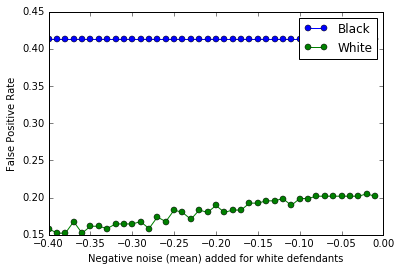

In [39]:
xaxis = np.arange(-0.4, 0, 0.01)
plt.plot(xaxis, 
         np.full(len(xaxis), fpr(true_recid_aa, decisions_aa)),
         label = 'Black', marker='o')
plt.plot(xaxis, fprs, label= 'White', marker='o')
plt.xlabel('Negative noise (mean) added for white defendants')
plt.ylabel('False Positive Rate')
#plt.ylim(0,1)
plt.legend()

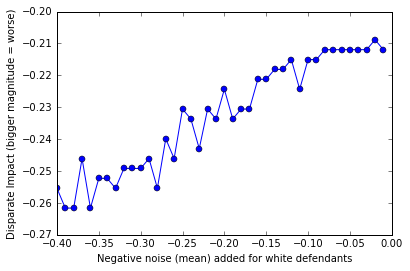

In [40]:
plt.plot(xaxis, dis, marker='o')
plt.xlabel('Negative noise (mean) added for white defendants')
plt.ylabel('Disparate Impact (bigger magnitude = worse)')

Other g(x) to try - 
* switch some percentage of decisions in the extremes
* disproportionate noise
* catch errors (one-sided, disproportionate)